In [1]:
import nexradaws
import tempfile
import os
import shutil
import pyart
from matplotlib import pyplot as plt
from netCDF4 import num2date
import numpy as np
import cftime

from dask_kubernetes import KubeCluster
from dask.distributed import Client, TimeoutError
from dask.distributed import wait, progress
#import six


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/client.py:2: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import defaultdict, Iterator
/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/scheduler.py:2: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import defaultdict, deque, OrderedDict, Mapping, Set
/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/scheduler.py:2: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import defaultdict, deque, OrderedDict, Mapping, Set


In [3]:
#As it can take some time to spin up first start the Dask cluster
# Select 20 'workers' under 'manual scaling' menu below and click 'Scale'
# Click on the 'Dashboard link' to monitor calculation progress
try:
    client = Client('tcp://localhost:33949', timeout='2s')
    new_cluster = False
except:
    print('NOOO!')
    cluster = KubeCluster(n_workers=20)
    cluster
    new_cluster = True

NOOO!


In [4]:
cluster

In [5]:
def simple_sum(filename):
    try: #catch two common errors
        this_dataset = pyart.aux_io.read_odim_h5(filename)
        fp = 1
        time_start = num2date(this_dataset.time['data'][0], this_dataset.time['units'])
        tgates = float(this_dataset.ngates*this_dataset.nrays)
        zdat = this_dataset.fields['reflectivity']['data']
        fp = 2
        z0 = float(len(np.where(zdat > 0.)[0]))/tgates
        z10 = float(len(np.where(zdat > 10.)[0]))/tgates
        z40 = float(len(np.where(zdat > 40.)[0]))/tgates
                
        grids = pyart.map.grid_from_radars(this_dataset,(31,401,401),
                   ((0.,15000.),(-200000.,200000.),(-200000.,200000.)),
                   fields=this_dataset.fields.keys(),
                   refl_field='reflectivity', weighting_function='BARNES2')  
        
        z_prof_mean = grids.fields['reflectivity']['data'].mean(axis=(1,2))
        z_prof_max = grids.fields['reflectivity']['data'].max(axis=(1,2))
        npts_over = np.array([float(len(np.where(grids.fields['reflectivity']['data'][i, :, :] > 10.)[0]))\
                      for i in range(grids.fields['reflectivity']['data'].shape[0])])
        
        del this_dataset, grids
        rv = (time_start, z0, z10, z40, 
              z_prof_mean, z_prof_max, npts_over)
    except (TypeError, KeyError) as e:
        rv = 'error'
    return rv


In [6]:
indir = os.path.expanduser('~/data/aus/terryhills/')

In [7]:
files = os.listdir(indir)

In [8]:
files = [os.path.join(indir, thise) for thise in files]

In [9]:
simple_sum(files[0])

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


(real_datetime(2018, 12, 20, 4, 54, 28),
 0.04478852513227513,
 0.03195982142857143,
 0.0047240410052910055,
 masked_array(data=[17.81810247873146, 17.371086935452606,
                    17.197531868425745, 17.555091585374413,
                    18.336207353721054, 18.782215749824807,
                    19.086234149655123, 19.371569315857,
                    19.631417123757284, 19.759159755234148,
                    20.004163590294326, 20.047691428382095,
                    20.05997122856487, 20.11392268125408,
                    20.015706454450672, 19.904804700294793,
                    19.76370686794957, 19.650084299173106,
                    19.462844428188248, 19.295947219604148,
                    19.13794215970132, 18.921072892685487,
                    18.757475002164316, 18.521300422138836,
                    18.257407551677574, 18.07272488456074,
                    18.032735742146322, 18.083984375, 18.286575605591718,
                    18.587862171566076, 19.076

In [10]:
# Attach Dask to the cluster
if new_cluster:
    client = Client(cluster)

In [11]:
client

Client Scheduler: tcp://10.48.128.15:45391 Dashboard: /user/scollis-ausopenradar2019-40ruzb12/proxy/8787/status,Cluster Workers: 15 Cores: 30 Memory: 105.00 GB


In [12]:
future = client.map(simple_sum, files)


In [13]:
progress(future)

VBox()

In [14]:
my_data = client.gather(future)

In [ ]:
#my_data = client.gather(future)

In [15]:
#filtered_data = filter(lambda i:not(type(i) is str), my_data)
filtered_data = [value for value in my_data if type(value) != str]

In [16]:
times = np.array([tpl[0] for tpl in filtered_data])
z0 = np.array([tpl[1] for tpl in filtered_data])
z10 = np.array([tpl[2] for tpl in filtered_data])
z40 = np.array([tpl[3] for tpl in filtered_data])
zprof = np.array([tpl[4] for tpl in filtered_data])
zprofmax = np.array([tpl[5] for tpl in filtered_data])
npts = np.array([tpl[6] for tpl in filtered_data])



In [17]:
order = np.argsort(times)

In [18]:
nptimes = times.astype('datetime64[ns]')

/srv/conda/envs/notebook/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


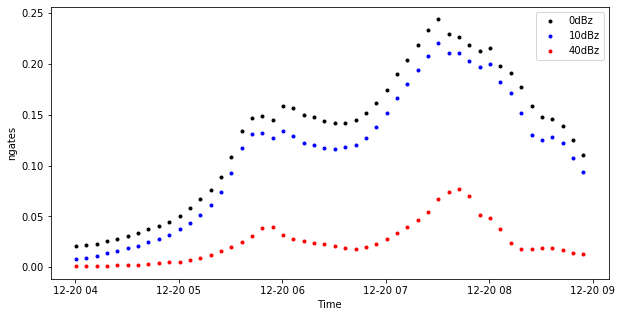

In [19]:
my_fig = plt.figure(figsize=[10,5])
plt.plot(nptimes[order], z0[order], '.k', label='0dBz')
plt.plot(nptimes[order], z10[order], '.b', label='10dBz')
plt.plot(nptimes[order], z40[order], '.r', label='40dBz')
plt.ylabel('ngates')
plt.xlabel('Time')
plt.legend()

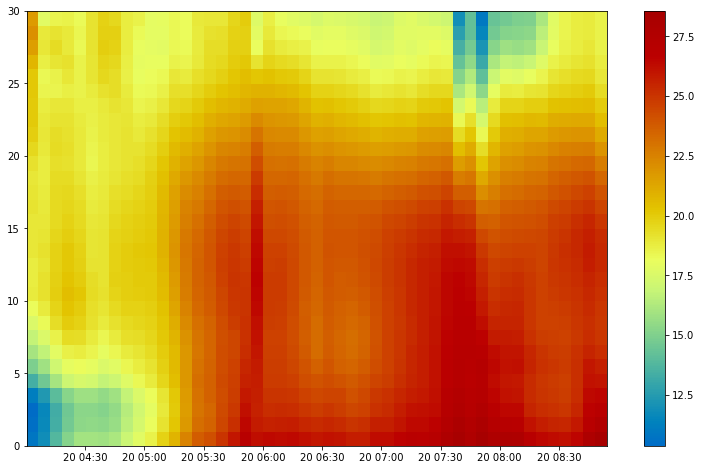

In [20]:
fig = plt.figure(figsize=[13,8])
plt.pcolormesh(nptimes[order], range(31), zprof[order].transpose(),
              cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
plt.colorbar()

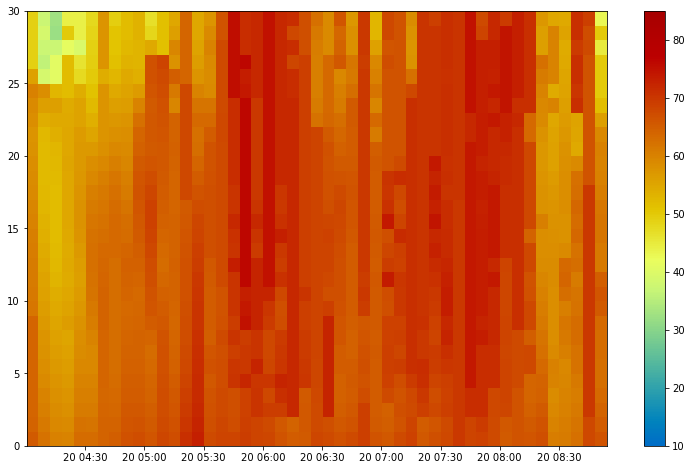

In [25]:
fig = plt.figure(figsize=[13,8])
plt.pcolormesh(nptimes[order], range(31), zprofmax[order].transpose(), vmin=10, vmax=85,
               cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
plt.colorbar()

In [ ]:
fig = plt.figure(figsize=[13,8])
plt.pcolormesh(times[order], range(31), npts[order].transpose()/(801**2),
               cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
plt.colorbar()

In [ ]:
z_prof_max = grids.fields['reflectivity']['data'].max(axis=(1,2))

In [ ]:
npts_over = np.array([float(len(np.where(grids.fields['reflectivity']['data'][i, :, :] > 10.)[0]))\
                      for i in range(grids.fields['reflectivity']['data'].shape[0])])

In [ ]:
npts_over